In [16]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet152, ResNet152_Weights
from sklearn.metrics import f1_score

import os

# 디바이스 설정 (GPU 사용 가능 여부 확인)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# 데이터 증강 및 전처리
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # 더 큰 회전 적용
        transforms.RandomVerticalFlip(),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
        
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 데이터셋 로드
data_dir = "../../data/binary_label_classifier"
categories = os.listdir(data_dir)  # 14개의 카테고리
assert len(categories) == 14, "카테고리 갯수가 14개가 아닙니다."

# Train/Validation 데이터셋 준비
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# 사전 학습된 모델 불러오기 및 수정
model = resnet152(weights=ResNet152_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 14)  # 14개의 카테고리로 분류
model = model.to(device)

# 손실 함수 및 최적화 함수 정의

criterion = nn.CrossEntropyLoss()
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 학습 루프
def train_model_with_f1_and_accuracy(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # F1 Score 계산을 위한 저장
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # F1 스코어 계산
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')  # 가중 평균 F1 스코어

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")

            if phase == 'val' and epoch_f1 > best_f1:  # F1 기준으로 Best Model 저장
                best_f1 = epoch_f1
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f"Best val Acc: {best_acc:.4f} F1: {best_f1:.4f}")
    model.load_state_dict(best_model_wts)
    return model

# 학습 시작
model = train_model_with_f1_and_accuracy(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=100)

# 모델 저장
torch.save(model.state_dict(), "resnet50_14_classes_with_f1_and_acc.pth")


cuda


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100.0%


Epoch 1/100
----------


/workspace/ComputerVision/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 2.2248 Acc: 0.3063 F1: 0.2822
val Loss: 1.9900 Acc: 0.4640 F1: 0.4320
Epoch 2/100
----------
train Loss: 1.9354 Acc: 0.4073 F1: 0.3824
val Loss: 1.7767 Acc: 0.5105 F1: 0.4845
Epoch 3/100
----------
train Loss: 1.8489 Acc: 0.4151 F1: 0.3952
val Loss: 1.7919 Acc: 0.5194 F1: 0.4922
Epoch 4/100
----------
train Loss: 1.7629 Acc: 0.4499 F1: 0.4303
val Loss: 1.6556 Acc: 0.5443 F1: 0.5226
Epoch 5/100
----------
train Loss: 1.7309 Acc: 0.4529 F1: 0.4351
val Loss: 1.6487 Acc: 0.5506 F1: 0.5303
Epoch 6/100
----------
train Loss: 1.6910 Acc: 0.4665 F1: 0.4500
val Loss: 1.5898 Acc: 0.5656 F1: 0.5517
Epoch 7/100
----------
train Loss: 1.6752 Acc: 0.4729 F1: 0.4577
val Loss: 1.6522 Acc: 0.5703 F1: 0.5598
Epoch 8/100
----------
train Loss: 1.6588 Acc: 0.4809 F1: 0.4675
val Loss: 1.5470 Acc: 0.5894 F1: 0.5738
Epoch 9/100
----------
train Loss: 1.6462 Acc: 0.4849 F1: 0.4716
val Loss: 1.5386 Acc: 0.5969 F1: 0.5884
Epoch 10/100
----------
train Loss: 1.6165 Acc: 0.4813 F1: 0.4716
val Loss: 1.

KeyboardInterrupt: 

In [13]:
wrong_predictions = []  # 틀린 예측을 저장할 리스트

for inputs, labels in dataloaders['val']:
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward 패스
    with torch.no_grad():
        outputs = model(inputs)
        topk_vals, topk_preds = torch.topk(outputs, 2, dim=1)  # 상위 2개 값과 인덱스를 가져옴

    # 틀린 예측 확인
    for i in range(inputs.size(0)):
        if topk_preds[i, 0] != labels[i]:  # 1순위 예측이 틀렸다면
            wrong_predictions.append({
                'input': inputs[i].cpu(),  # 틀린 이미지 텐서
                'predicted_1st': topk_preds[i, 0].item(),  # 1순위 예측 클래스
                'predicted_2nd': topk_preds[i, 1].item(),  # 2순위 예측 클래스
                'actual': labels[i].item()    # 실제 클래스
            })


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/workspace/ComputerVision/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/workspace/ComputerVision/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/workspace/ComputerVision/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/workspace/ComputerVision/.venv/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 245, in __getitem__
    sample = self.loader(path)
  File "/workspace/ComputerVision/.venv/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 284, in default_loader
    return pil_loader(path)
  File "/workspace/ComputerVision/.venv/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 262, in pil_loader
    with open(path, "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: '../../data/binary_label_classifier/Part Others/305018304947/3.jpg'


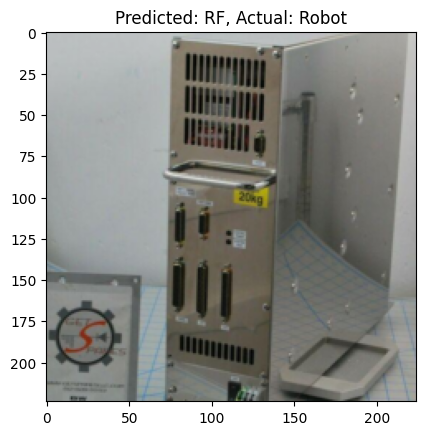

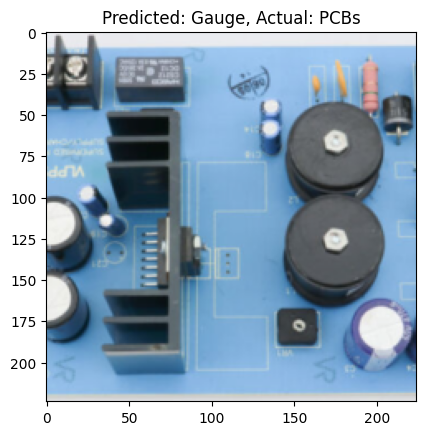

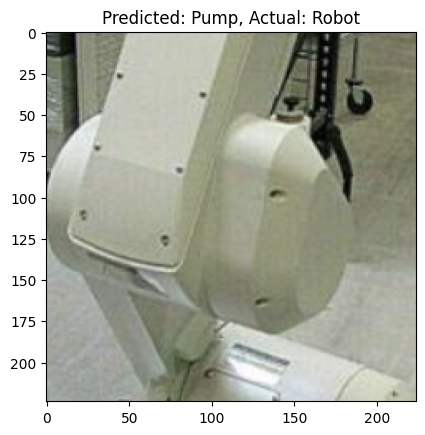

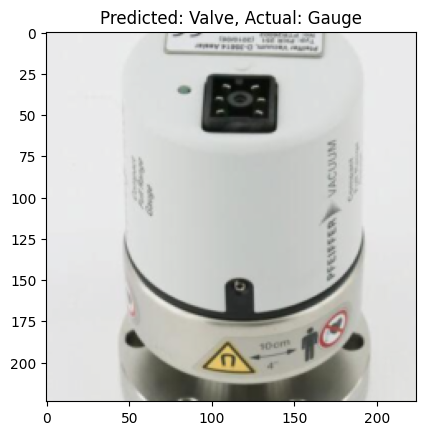

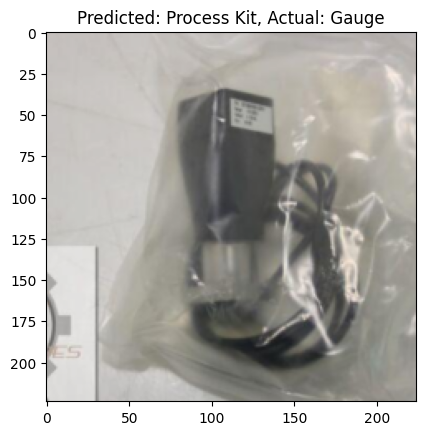

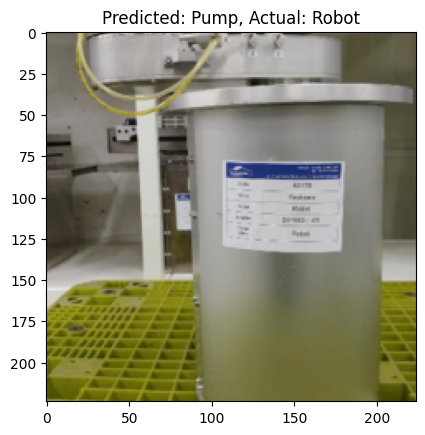

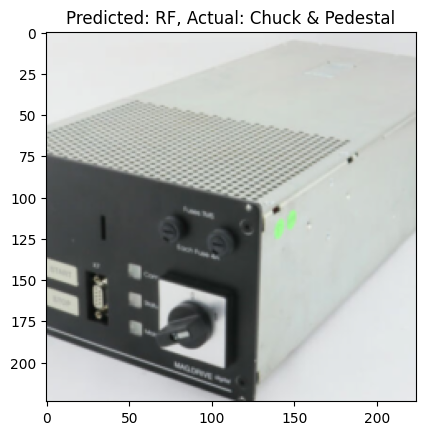

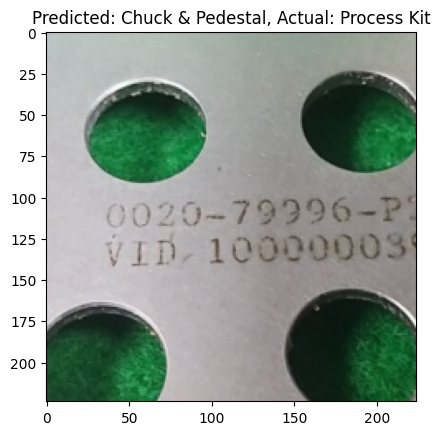

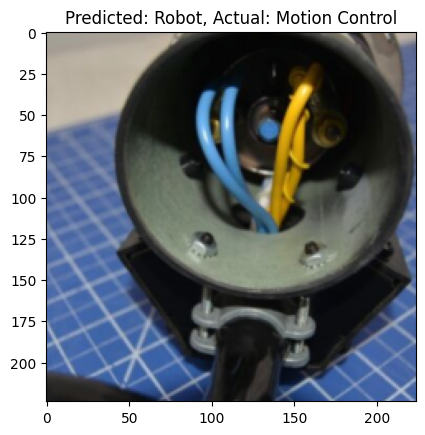

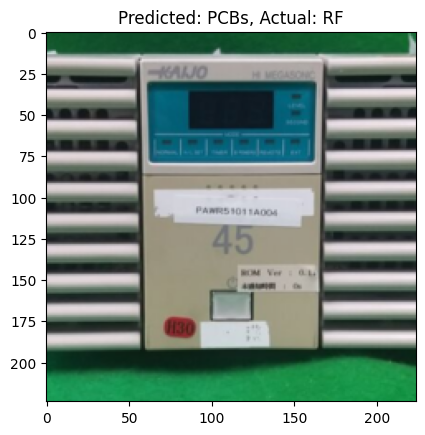

In [10]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(inp, title=None):
    """이미지 시각화 함수"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.show()

# 틀린 예측 시각화
for i, wrong in enumerate(wrong_predictions[10:20]):  # 처음 10개 틀린 예측 출력
    imshow(wrong['input'].cpu(), 
           title=f"Predicted: {class_names[wrong['predicted']]}, Actual: {class_names[wrong['actual']]}")


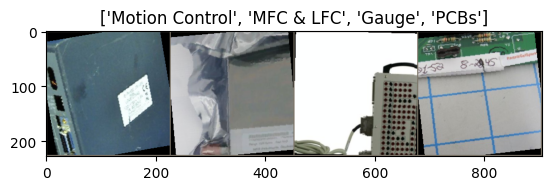

In [7]:
import matplotlib.pyplot as plt
example_loader = DataLoader(image_datasets['train'], batch_size=4, shuffle=True)
inputs, classes = next(iter(example_loader))

# 증강된 이미지 시각화
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# 배치 시각화
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

# 데이터 디렉토리 설정
data_dir = "../../data/MLPoC"

# 데이터 탐색: 파일 경로와 라벨 매핑
def load_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # 카테고리 이름 (정렬하여 라벨 순서 고정)
    
    for label, category in enumerate(class_names):
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):
            continue
        
        for subcategory in os.listdir(category_path):
            subcategory_path = os.path.join(category_path, subcategory)
            if not os.path.isdir(subcategory_path):
                continue
            
            for img_file in os.listdir(subcategory_path):
                if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
                    image_paths.append(os.path.join(subcategory_path, img_file))
                    labels.append(label)  # 카테고리 라벨 추가
                    
    return image_paths, labels, class_names

# 데이터 로드
image_paths, labels, class_names = load_image_paths_and_labels(data_dir)
print(f"총 이미지 수: {len(image_paths)}, 총 클래스 수: {len(class_names)}")

# Train/Validation 분할
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# 이미지 전처리 함수
def preprocess_image(image_path, label):
    # 이미지 로드 및 전처리
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.keras.applications.resnet50.preprocess_input(img)  # ResNet50 전처리
    return img, label

# 데이터 증강 함수
def augment_image(image, label):
    # 데이터 증강
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

# TensorFlow 데이터셋 정의
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

# ResNet50 모델 구성
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# 모델 저장
model.save("resnet50_14_classes_tfdata.h5")

# 검증 단계에서 틀린 예측 확인
val_predictions = model.predict(val_ds, verbose=1)
predicted_classes = tf.argmax(val_predictions, axis=-1).numpy()
true_classes = tf.concat([y for x, y in val_ds], axis=0).numpy()

wrong_indices = [i for i, (pred, true) in enumerate(zip(predicted_classes, true_classes)) if pred != true]

print(f"틀린 예측 개수: {len(wrong_indices)}")
for idx in wrong_indices[:10]:  # 처음 10개의 틀린 예측 출력
    print(f"틀린 샘플 - Index: {idx}, Predicted: {class_names[predicted_classes[idx]]}, Actual: {class_names[true_classes[idx]]}")


2025-01-09 08:30:14.942631: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 08:30:14.949138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 08:30:14.956670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 08:30:14.959074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 08:30:14.965182: I tensorflow/core/platform/cpu_feature_guar

총 이미지 수: 6723, 총 클래스 수: 14


I0000 00:00:1736411416.104352  172923 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-09 08:30:16.124781: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.2783 - loss: 2.5662 - val_accuracy: 0.1175 - val_loss: 88.5619
Epoch 2/20
46/85 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.3907 - loss: 1.9489

KeyboardInterrupt: 